# Stock Price Prediction, using SageMaker DeepAR


DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates:
- How to format Deutsche Börse maintained stock market data to be used as training input and prediction on DeepAR
- Usage of `Dynamic Features` on DeepAR, with metrices within the Deutsche Börse dataset used as dynamic features
- How to easily train an DeepAR Estimator and create a Predictor using DeepAR container image

Running the model training using the highest memory CPU based [ML instance type](https://aws.amazon.com/sagemaker/pricing/instance-types/) available on AWS at this time (`ml.c5.18xlarge`), it should take about 15 minutes to train the model if you use data sampled at daily interval.


In [10]:
from __future__ import print_function
import os
import datetime
import sagemaker
import pandas as pd
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox
import matplotlib
import deepar_util as util
from deepar_util import DeepARPredictor

## Choice of Series

As we observed during data analysis phase that there are certain stocks that are clustered relatively more, based on their past price trends. Naturally, using these similarly moving stock would increase overall model performance, in absence of any other available external time series.

Therefore, like before, use the stocks of companies in automobile industry, and tjhe closing price of these series as the time series' of choice, for the model to build upon. THe difference here however is that, we do not have to specify which is the main series, and which ones are exogenous. DeepAR algorithm works to build a model that accounts for trends in all provided time series, and can generate forecast on any of those. This saves you the hassle of building different models for different time series.

Just like we used covariate time series in our custom RNN example, we can use such series on DeepAR, by using the Dynamic Features. The data formatting function works to take all covariate columns, and format those as dynamic features for each time series.

So, in effect, following the configuration below, you end up having 6 time series' - the closing prices of the 6 stocks, each with 3 dynamic feature series' - opening price, and minimum and maximum prices.

In [11]:
#Define parameters
interval = 'D' #Use D or H

assert interval == 'D' or interval == 'H'

if interval == 'D':
    prediction_length = 91 #when interval = D    
    context_length = 91
elif interval == 'H':
    prediction_length = 2184 #when interval = H
    context_length = 2184
    
    
mnemonics = ['IBM','AAPL','AMZN','MSFT']
target_column = 'EndPrice'
covariate_columns = ['StartPrice', 'MinPrice', 'MaxPrice']

train_test_split = 0.8
num_test_windows = 4
    
hyperparameters = {
    "prediction_length": str(prediction_length), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

## Hyperparameters

In our custom RNN example, we implemented the training code, so that certain aspects of training can be customized using hyperparamaters. In case of DeepAR, like any AWS provided algorithms, you can use similar hyparparameters configuration to get the most out of your model.

[DeepAR Hhyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html) allows you to control certain aspects of your NN architecture, such as number of layers, number of recurrent units in each layer, learning rate, prediction length and context (horizon and lag), dropout rate etc. In the cell above we configured some, so as to get good accuracy, within a reasonable training time, as suitable or this workshop.

In practice, you can use another valuable feature of SageMaker - [Hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) to conduct a sort of grid search over your hyperparameters space and find the best combination for your use case.

In [12]:
# Define IAM role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
print("Model will be trained using container image : {}".format(image_name))

#Define training data location
s3_data_key = 'dbg-stockdata/source'
s3_bucket = 'alphavantage-dcap'
s3_output_path = "s3://{}/{}/{}/output".format(s3_bucket, s3_data_key, interval)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Model will be trained using container image : 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest


## Training Data

During data preparation steps, you uploaded the resampled data to your S3 bucket, attached to your SageMaker session, under an appropriate prefix, depending on resampling interval. 

In order to use the data for DeepAr however, you'll need to do some preprocessing to have the data formatted following [DeepAR Input/Output interface](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput). 
The function named `deeparize` in the utility file - [deepar_util.py](./deepar_util.py) does this transformation.

In [13]:
%%time
metrics=[]
metrics.extend(covariate_columns)
metrics.append(target_column)
stock_data_series, symbols = util.load_resampled_from_s3(interval, s3_bucket, s3_data_key, mnemonics, metrics)
print(stock_data_series.shape)

(178, 16)
CPU times: user 97.7 ms, sys: 23 µs, total: 97.7 ms
Wall time: 138 ms


Finally you split the formatted data into training and test channels and host on your S3 bucket, to be fed into estimator at training phase.

Notice here, unlike our custom RNN code, where the train-test split was done inside the container, DeepAR expects you to do the split outside and provide the data as separate channels.

In [14]:
%%time
train_data, test_data, train_start_dt, train_end_dt = util.generate_train_test_set(stock_data_series, target_column, covariate_columns, interval, train_test_split, num_test_windows)
end_training = pd.Timestamp(datetime.datetime.strptime(str(train_end_dt), "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S"), freq = interval)

train_channel = util.write_dicts_to_file(train_data, interval, s3_bucket, s3_data_key, "train")
test_channel = util.write_dicts_to_file(test_data, interval, s3_bucket, s3_data_key, "test")
print("Train channel {}".format(train_channel))
print("Test channel {}".format(test_channel))

Sample Size = 178, Training Set: 142, Test Set: 4 * 9
Training Set: Starts at - 2020-04-29 00:00:00, Ends at - 2020-09-17 00:00:00
Time series for AAPL added
Dynamic Feature - MaxPrice for AAPL added
Dynamic Feature - MinPrice for AAPL added
Dynamic Feature - StartPrice for AAPL added
Time series for AMZN added
Dynamic Feature - MaxPrice for AMZN added
Dynamic Feature - MinPrice for AMZN added
Dynamic Feature - StartPrice for AMZN added
Time series for IBM added
Dynamic Feature - MaxPrice for IBM added
Dynamic Feature - MinPrice for IBM added
Dynamic Feature - StartPrice for IBM added
Time series for MSFT added
Dynamic Feature - MaxPrice for MSFT added
Dynamic Feature - MinPrice for MSFT added
Dynamic Feature - StartPrice for MSFT added
Time series for AAPL added
Dynamic Feature - MaxPrice for AAPL added
Dynamic Feature - MinPrice for AAPL added
Dynamic Feature - StartPrice for AAPL added
Time series for AMZN added
Dynamic Feature - MaxPrice for AMZN added
Dynamic Feature - MinPrice fo

To validate that the series chosen indeed contains the correlated features that we hoped for, and that the deparize-transformation is working as expected, you can plot the series values - on separate plots, and on single plots.

This is an optional step, but it often is a agood idea to have the data sanity checked before feeding to the model, to avoid costly mistakes later on.

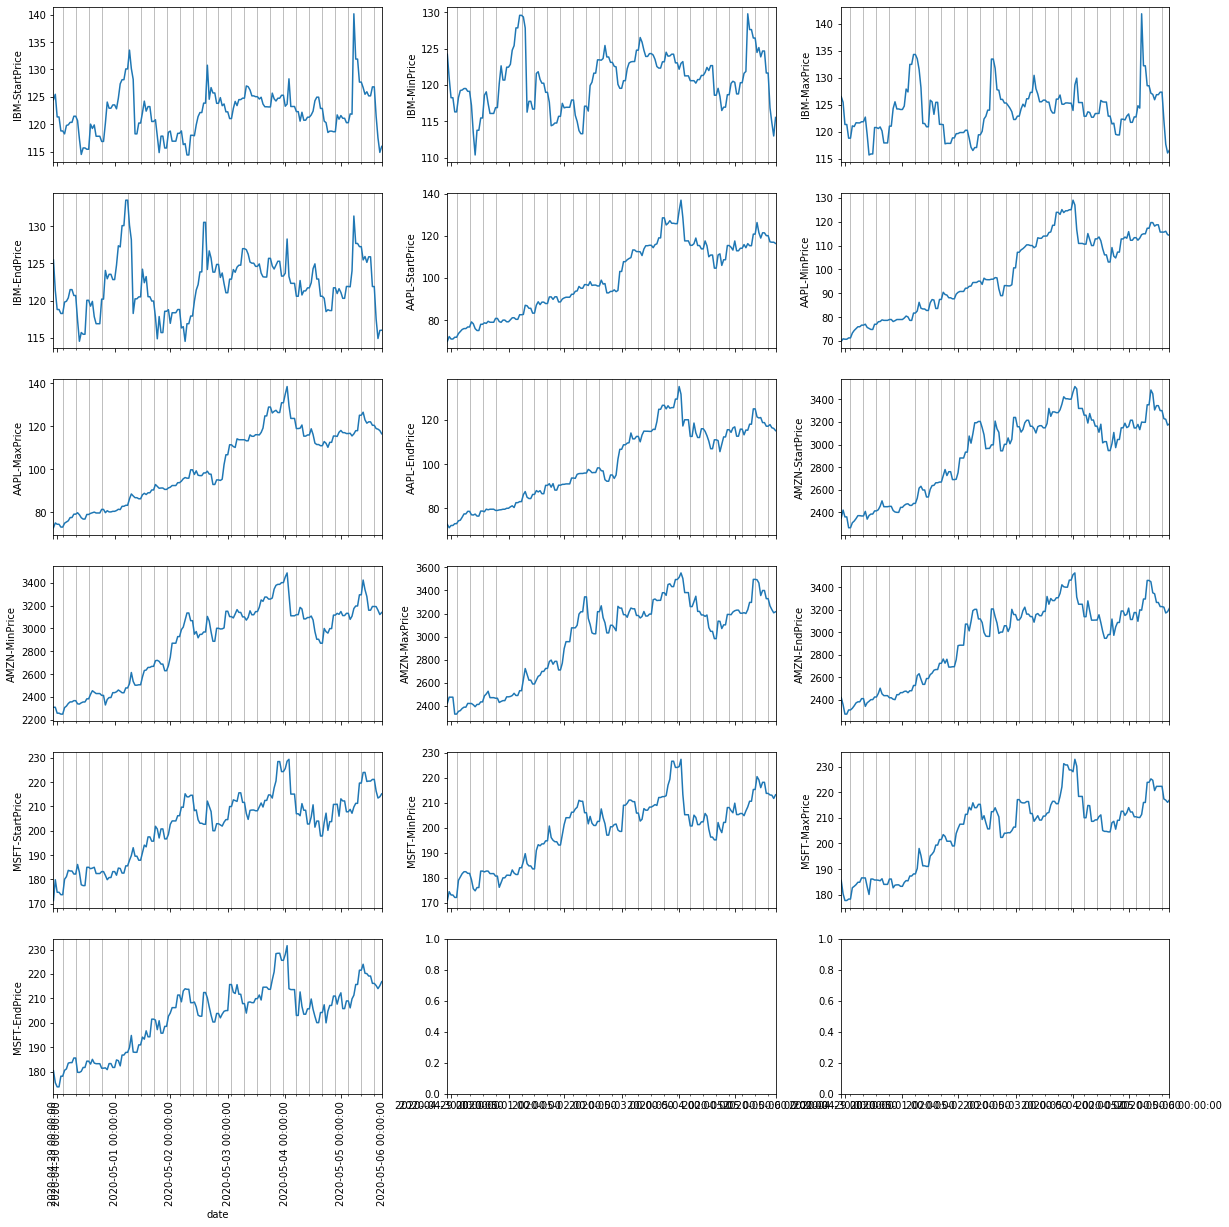

In [15]:
util.metrics_plot(mnemonics, metrics, stock_data_series)

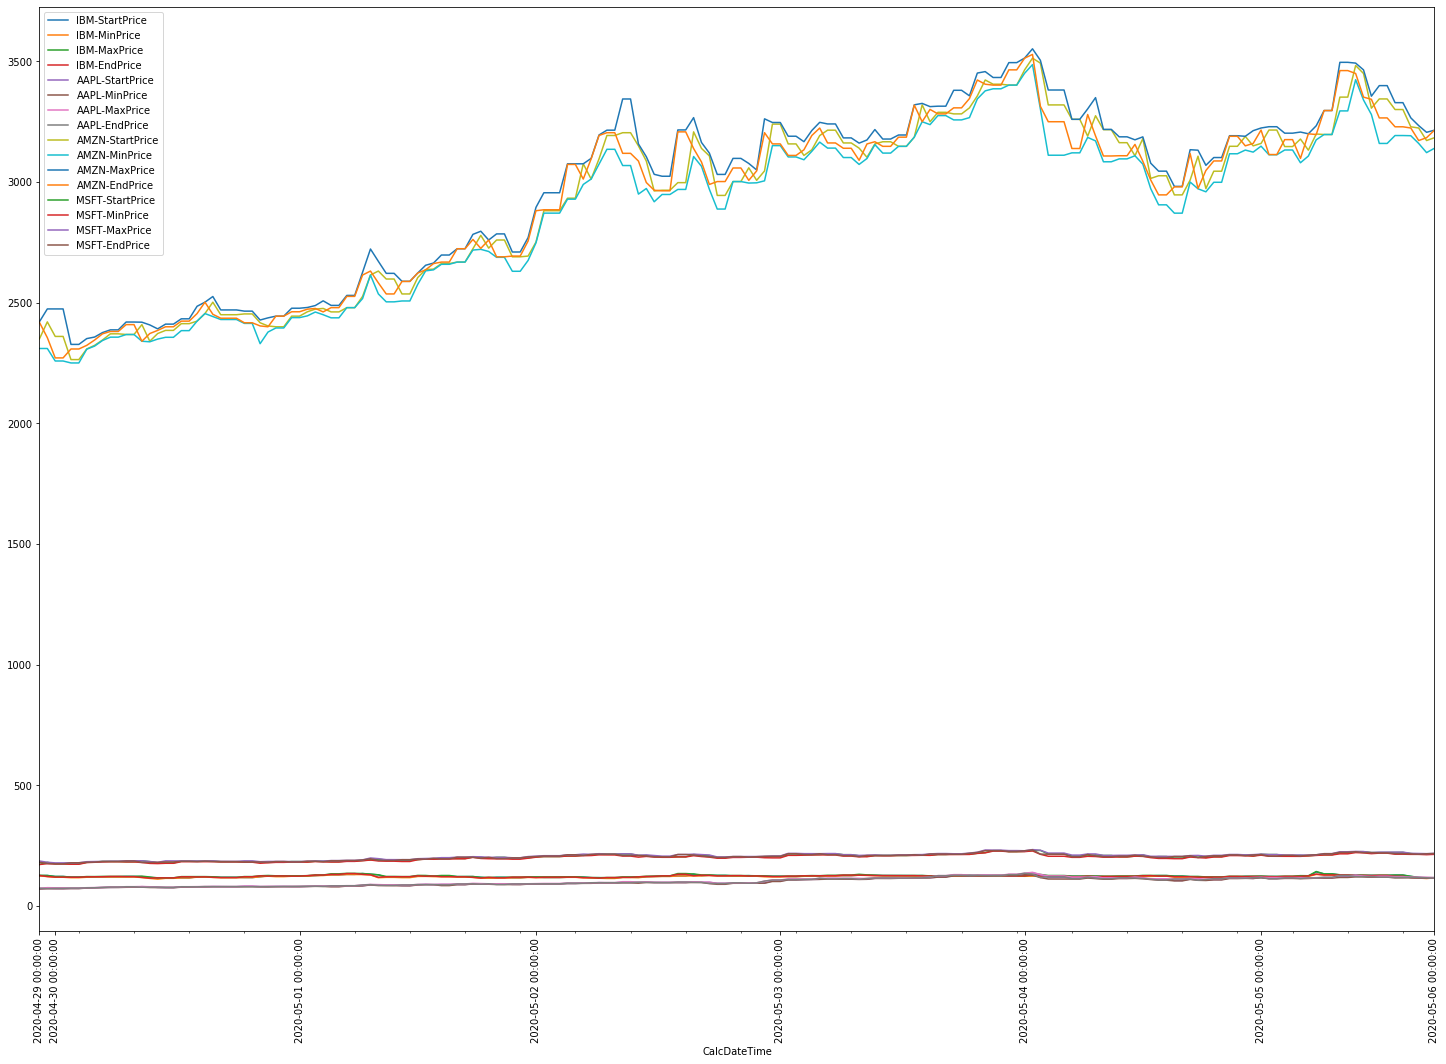

In [16]:
matplotlib.rcParams['figure.figsize'] = (25, 17) # use bigger graphs
util.timeseries_plot(mnemonics, metrics, stock_data_series)

## Model Training

Just like in the previous module, you'll use SageMaker's high level [Estimator API](https://sagemaker.readthedocs.io/en/latest/estimators.html) to submit a training job, with only difference being, here you use the training image for SageMaker DeepAR that you obtained for the AWS region that you are running thhis workshop in. 

Following are the necessary inputs while submitting a training job:
- Uniquely identifiable job name
- SageMaker algorithm image path where the DeepAR training code is available
- URLs of the Amazon S3 bucket where you have the training and test data stored
- URL of the S3 bucket where you want to store the output of the job (upon training completion SageMaker archives the model artifacts and makes those available as a tar-file named `model.tar.gz` at the specified location on S3)


In [17]:
%%time

# Instantiate estimator with container image for DeepAR and backend EC2 instance(s)
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.18xlarge',
    base_job_name='dbg-deepar-{}'.format(interval),
    output_path=s3_output_path
)

# Set the hyperparamters
estimator.set_hyperparameters(**hyperparameters)

# Specify data channels
data_channels = {
    "train": train_channel,
    "test": test_channel
}

# Train the model
estimator.fit(inputs=data_channels, wait=True)

#Wait for training to finish
estimator_job = estimator.latest_training_job.job_name
print("Estimator created at completion of training job {}".format(estimator_job))

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-26 11:40:27 Starting - Starting the training job...
2020-10-26 11:40:29 Starting - Launching requested ML instances......
2020-10-26 11:41:43 Starting - Preparing the instances for training......
2020-10-26 11:42:49 Downloading - Downloading input data...
2020-10-26 11:43:22 Training - Training image download completed. Training in progress.
2020-10-26 11:43:22 Uploading - Uploading generated training model
2020-10-26 11:43:22 Failed - Training job failed
Arguments: train
[10/26/2020 11:43:18 INFO 140444308318016] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'a

UnexpectedStatusException: Error for Training job dbg-deepar-D-2020-10-26-11-40-27-527: Failed. Reason: ClientError: You have configured context_length=91 and prediction_length=91, but the average time series length in the data is only 142. Consider decreasing the context and/or prediction length such that average time series length is larger than the sum of context length and prediction length.

While the training job is running, you can observe the output and notice that DeepAR outputs the average epoch loss obtained after each epoch and reports on the best epoch loss obtained so far.

At the end of the training, the algorithm chooses the best loss over all epochs, obtains a test score using  the data available throrugh test channel, and reports the RMSE and quantile loss at various conofidence levels raning from `0.1` through `0.9`.

## Model Deployment

As before, you'll use the `deploy` method on your trained `Estimator` to create a hosted model definition,confgure the endpoint, and deploy the model to the endpoint - all in one go.

Another nice feature of Estimator API is that you can extend the [RealTimePredictor](https://sagemaker.readthedocs.io/en/latest/predictors.html) class and create a custom class, with methods to do prep-processing on data. This feature is useful in this case, as DeepAR prediction endpoint expects JSON serialized strings, and in Python we use DataFrames to load the data and work with it.

Therefore, you use a custom predictor class - `DeepARPredictor`, as defined in [deepar_util.py](./deepar_util.py) that allows you to query the endpoint and perform predictionsusing `pandas.Series` objects rather than raw JSON strings.

In [18]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)
print("Pedictor attached to Endpoint: {}".format(predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://alphavantage-dcap/dbg-stockdata/source/D/output/dbg-deepar-D-2020-10-26-11-40-27-527/output/model.tar.gz.

## Forecasting and Plotting

Upon completion of deployment, your predictor will have an handle to the endpoint you just provisioned. 

If using this notebook at any later time, or with a previously deployed endpoint, you can simply obtain a handle to the the endpoint, by specifying the right estimator job name, and instantiating a `DeepARPredictor` with the job name.

In [19]:
#Use a job name from previous training, 
#if you need to connect to a pre-deployed endpoint.

#When running in one session, predictor is already initialized when 'deploy' method returns. 

#estimator_job = 'dbg-deepar-D-2018-11-20-03-48-43-169'

predictor = DeepARPredictor(estimator_job)

NameError: name 'estimator_job' is not defined

To make forecast for a particular stock, you simply use another utility method to extract time series and dynamic features for the chosen stock that you want to forecast, between the dates chosen.

Also, notice that while requesting prediction forecast to a DeepAR endpoint, you can specify the quantiles, as needed, and the endpoint return results at various confidence levels, as specified in the request.

In [ ]:
ts, dynamic_feat, observed = util.query_for_stock('BMW', target_column, covariate_columns, stock_data_series, prediction_length)
prediction = predictor.predict(ts=ts, dynamic_feat = dynamic_feat, quantiles=[0.10, 0.5, 0.90], return_samples=False)
prediction.head()

In [ ]:
util.plot_predicted_observed_at_quantile(ts, observed, prediction, prediction.columns[-1])

Since with DeepAR, you are not limited to geenrating prediction with just one main series, feel free to use the widget to choose different stocks, and generate forecasts at various confidence levels, with varying forecast horizons.

On each execution, you also use an utility method to to plot the observed values, overlayed with the forecasted spread.

In [ ]:
style = {'description_width': 'initial'}
@interact_manual(
    stock_id=IntSlider(min=0, max=len(mnemonics)-1, value=0, style=style),     
    forecast_horizon=IntSlider(min=0, max=int(context_length*0.75), steps = int(np.log10(context_length))+1, value=int(np.log10(context_length))+1, style=style),
    confidence=IntSlider(min=55, max=95, value=80, step=5, style=style),
    history_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(stock_id, forecast_horizon, confidence, history_plot, show_samples):
    util.plot(
        predictor,
        stock_id,
        mnemonics,
        stock_data_series,
        target_column,
        covariate_columns,
        prediction_length,        
        history_plot*prediction_length,
        forecast_date=end_training 
                        + datetime.timedelta(days=forecast_horizon) if interval == "D"
                            else datetime.timedelta(hours=forecast_horizon) if interval == "H"
                            else datetime.timedelta(weeks=forecast_horizon) if interval == "W"
                            else datetime.timedelta(days=forecast_horizon*30) if interval == "M"
                            else 0,
        show_samples=show_samples,        
        confidence=confidence
    )

## Some Final Thoughts

1. We made improvements from our custom RNN code, by using stocks identified to belong to a cluster - `BMW`, `Chrysler`, `Volkswagon`, `Contiental` and `Porsche`, together as time series' in DeepAR model. Having a ARIMAx model trained across the cross sections of these individiual series' helped us improve upon the prediction, and allowe dus to generate forecast for any stocks within the collection.

1. We used closing price as target series to predict, and to demonstrate the dynamic feature, used opening, minimum and maximum price as covariates. However this is not possible in reality. The values of series' used as dynamic features need to be know across the forecast horizon. Therfore the accuracy that we experience above is somewhat artificial, in that we are forecasting closing prices, knowing the opening, minimum and maximum prices, which is impossible.

1. To use dynamic features, in reality, you need to find data sources that can be known before, These could be:
    - Companies' forward looking sales/revenue targets
    - Analysts guidances on stock prices
    - Economic forecasts from other sources
    - Price trends of future options, base don the underlying stock

Be creative, find data sources that can effectively be used, and feel free to share your findings by emailing the author of the workshop at [binoyd@amazon.com](mailto:binoyd@amazon.com)

## Delete EndPoint

Keep in mind that a running EndPoint has the chosen compute instances running, regardless of whether or not requests are being sent.

Therefore, in order to contain cost overrun, you should always delete the unused EndPoints. This doesn't delete the trained model artefacts, and at any point, the EndPoint can be reprovisioned, simply by using the correspodning training job name.


In [ ]:
predictor.delete_endpoint()